# Easy21 Task #2 & 3

Max Schrader

In [79]:
from enum import Enum
from random import uniform, randint, choice, random
import plotly.graph_objects as go

## Creating the Objects

### Cards

### The Player

### The Dealer

### The Observed State

### The Game

In [259]:
from copy import copy, deepcopy
from random import random, choice, randint, uniform

ACTIONS = {1: 'STICK', 0: 'HIT'}


class Cards:
    def __init__(self):
        self.distribution_range = (1, 10)

    def get_card(self, first=False):
        return randint(*self.distribution_range) * 1 if (uniform(0, 1) < 2 / 3) or first \
            else -1 * randint(*self.distribution_range)


class Player:
    def __init__(self):
        self._cards = []
        self._sum = 0

    def check_bust(self):
        if self._sum < 0 or self._sum > 21:
            return True
        return False

    def clear_cards(self):
        self._cards = []
        self._sum = 0

    def add_card(self, card):
        self._cards.append(card)
        self._sum = sum(self._cards)

    def get_sum(self):
        return self._sum

    def get_card(self, index):
        return self._cards[index]


class Dealer(Player):
    STICK_THRESHOLD = 17

    def __init__(self):
        super(Dealer, self).__init__()

    def play_strategy(self, card):
        self.add_card(card)
        if not self.check_bust():
            if self.get_sum() < self.STICK_THRESHOLD:
                return True
        return False


class State:
    def __init__(self, player_sum, dealer_first):
        self.dealer_first = dealer_first
        self.player_sum = player_sum
        self.terminal = False

    def copy(self):
        return copy(self)


class Easy21:

    def __init__(self, ):
        self.dealer = Dealer()
        self.player = Player()
        self.cards = Cards()
        self.states = [range(1, 11), range(1, 22)]
        self.actions = ACTIONS
        self.actions_short = list(range(len(self.actions.keys())))

    def reset(self):
        self.__init__()

    def initialize_game(self):
        self.dealer.clear_cards()
        self.player.clear_cards()
        self.dealer.add_card(self.cards.get_card(first=True))
        self.player.add_card(self.cards.get_card(first=True))
        s = State(self.player.get_sum(), self.dealer.get_card(0))
        return s

    def calc_reward(self):
        if self.dealer.check_bust() or (self.player.get_sum() > self.dealer.get_sum()):
            return 1
        elif self.player.get_sum() == self.dealer.get_sum():
            return 0
        return -1

    def step(self, action, state):
        if action == 1:
            while self.dealer.play_strategy(self.cards.get_card()):
                pass
            r = self.calc_reward()
            state.terminal = True
        else:
            card = self.cards.get_card()
            self.player.add_card(card)
            if self.player.check_bust():
                state.terminal = True
                r = -1
            else:
                state.player_sum = self.player.get_sum()
                r = 0
        return state, r


class MonteCarloAgent:

    def __init__(self, gym: Easy21):
        self.gym = gym()
        self.Q = [[[0. for _ in range(len(self.gym.actions))] for _ in self.gym.states[0]] for _ in self.gym.states[1]]
        self.N = deepcopy(self.Q)
        self.N0 = 10000
        self.discount_factor = 1

    def calc_e(self, state: State) -> float:
        return self.N0 / (self.N0 + sum(self.N[state.player_sum - 1][state.dealer_first - 1][:]) * 1.)

    def get_best_action(self, state):
        rewards = self.Q[state.player_sum - 1][state.dealer_first - 1]
        max_reward = max(rewards)
        return choice([self.gym.actions_short[i] for i, reward in enumerate(rewards) if reward >= max_reward])

    def e_greedy(self, state):
        e = self.calc_e(state)
        if random() < e:
            return choice(self.gym.actions_short)
        else:
            return self.get_best_action(state)

    def update_q(self, history):
        for i, (s_k, a_k, r_k) in enumerate(history):
            p_i = s_k.player_sum - 1
            d_i = s_k.dealer_first - 1
            G_t = sum([r_j * (self.discount_factor ** j) for j, (_, _, r_j) in enumerate(history[i:])])
            self.N[p_i][d_i][a_k] += 1
            alpha = 1.0 / self.N[p_i][d_i][a_k]
            self.Q[p_i][d_i][a_k] += alpha * (G_t - self.Q[p_i][d_i][a_k])

    def _train(self, ):
        self.gym.reset()
        s_t = self.gym.initialize_game()
        history = []
        while not s_t.terminal:
            a_t = self.e_greedy(s_t)
            s_t_1, r_t = self.gym.step(a_t, s_t)
            history.append([s_t, a_t, r_t])
            s_t = s_t_1.copy()

        self.update_q(history)

    def run(self, iterations):
        for _ in range(int(iterations)):
            self._train()

    def get_V_star(self, ):
        player_sum = list(self.gym.states[1])
        dealer_showing = list(self.gym.states[0])
        V_star = [[max(actions) for actions in dealer] for dealer in self.Q]
        return player_sum, dealer_showing, V_star


In [260]:
mc_agent = MonteCarloAgent(gym=Easy21, )

In [261]:
mc_agent.run(iterations=int(5e5))

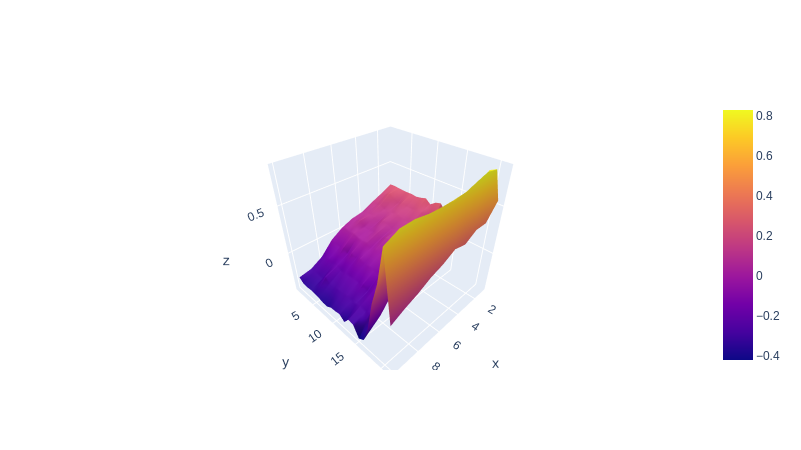

In [262]:
x, y, z = mc_agent.get_V_star()
fig = go.Figure(data=[go.Surface(z=z, x=y, y=x)])
fig.show()